In [274]:
# Standard library imports
import os
import sys
import re
import warnings
import random
import hashlib

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and preprocessing
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler  # Assuming you might need it

# Specific models and tools
from xgboost import XGBClassifier
import xgboost as xgb

# Encoding and feature selection
from category_encoders import TargetEncoder  # Fixed the import based on usage
from scipy.stats import randint, uniform

# Model persistence
from joblib import dump, load

# Miscellaneous settings
%matplotlib inline
warnings.filterwarnings('ignore')


In [275]:
competitions = [

    # Code, Seasons
    ['E0', [2324, 2223, 2122, 2021, 1920]],
    ['D1', [2324, 2223, 2122, 2021, 1920]],
    ['I1', [2324, 2223, 2122, 2021, 1920]],



]

In [276]:
matches_files = []

In [277]:
for comp in competitions:

    for season in comp[1]:

        matches_files.append(f"data/matches/{comp[0]}_{season}.csv")

In [278]:
# Load and concatenate matches data into a single DataFrame
df = pd.DataFrame()

for file in matches_files:

    try:
        df_temp = pd.read_csv(file)
        df = pd.concat([df, df_temp], ignore_index=True)
    except:
        # print an error message
        print(f'Error: {file} not found')

# print the amount of data loaded
print(f"Data loaded: {df.shape[0]} matches")

Data loaded: 5080 matches


In [279]:
df.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,BbMx>2.5,BbAv>2.5,BbMx<2.5,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA
0,E0,11/08/2023,20:00,Burnley,Man City,0,3,A,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,12/08/2023,12:30,Arsenal,Nott'm Forest,2,1,H,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,12/08/2023,15:00,Bournemouth,West Ham,1,1,D,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,12/08/2023,15:00,Brighton,Luton,4,1,H,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,12/08/2023,15:00,Everton,Fulham,0,1,A,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [280]:
# Convert 'Div' to a categorical type, a numeric representation of the division
df['Div'] = df['Div'].astype('category').cat.codes

In [281]:
# Create a unique list of HomeTeam and AwayTeam names combined, and add an index to each team
teams = pd.concat([df['HomeTeam'], df['AwayTeam']]).unique()

# Sort the teams alphabetically
teams.sort()

# Convert to an array of dictionaries
teams = [{'team': team, 'index': index} for index, team in enumerate(teams)]

In [282]:
# Create a unique list of Referees, and add an index to each Referee
referees = pd.concat([df['Referee']]).unique()

# Convert to an array of dictionaries
referees = [{'referee': referee, 'index': index} for index, referee in enumerate(referees)]

In [283]:
# Map the team names to the index values in the 'teams' list
df['Team_ID'] = df['HomeTeam'].map({team['team']: team['index'] for team in teams})
df['Opp_ID'] = df['AwayTeam'].map({team['team']: team['index'] for team in teams})

In [284]:
# Correcting the creation of a unique list of Referees and adding an index to each Referee
referees = df['Referee'].unique()  # This should directly refer to the 'Referee' column

# Sort the referees alphabetically
#referees.sort()

# Convert to a dictionary with referee names as keys and their indices as values
referee_dict = {referee: index for index, referee in enumerate(referees)}

# Now map the 'Referee' column to these indices
df['Ref_ID'] = df['Referee'].map(referee_dict)

In [285]:
# Date is in DD/MM/YYYY format, convert it to a datetime object
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# Declare Date_temp as a temporary column, an 8 digit integer representation of the date
df['Date_temp'] = df['Date'].dt.year * 10000 + df['Date'].dt.month * 100 + df['Date'].dt.day

# Connvert 'Time', which is now in HH:MM format to a 4 digit integer
# Assuming a default time of 00:00 for missing values
df['Time'] = df['Time'].fillna('00:00').str.replace(':', '').astype(int)

In [286]:
# Create an array of all HomeTeam and AwayTeam names
teams = np.append(df['HomeTeam'].unique(), df['AwayTeam'].unique())

In [287]:
df.columns = [re.sub(r'[<]', '_st_', str(col)) for col in df.columns]
df.columns = [re.sub(r'[>]', '_gt_', str(col)) for col in df.columns]

In [288]:
# Sort df by Date_temp and Time
df = df.sort_values(['Date_temp', 'Time'])

In [289]:
def history_vs_opponent_weighted(df, row, team_column):
    # Initialize the total weighted score
    weighted_score = 0
    opponent_column = 'Opp_ID'

    row_date_temp = row['Date'].year * 10000 + row['Date'].month * 100 + row['Date'].day

    
    # Filter the DataFrame for matches between the specified team and opponent from the same season, excluding the current match
    filtered_matches = df[(df[team_column] == row[team_column]) & 
                          (df[opponent_column] == row[opponent_column]) &
                          (df['Date_temp'] < row_date_temp)]
    
    #print(f"Filtered matches: {filtered_matches.shape[0]}")
    
    recent_matches = filtered_matches.sort_values(by='Date', ascending=False)
    
    # Calculate weights - newer matches have higher weights
    weights = range(len(recent_matches), 0, -1)  # Descending list based on the number of matches


    
    # Calculate score based on the match result
    for match, weight in zip(recent_matches.itertuples(), weights):
        if getattr(match, 'FTR') == 'H' and getattr(match, team_column) == getattr(match, 'Team_ID') or \
           getattr(match, 'FTR') == 'A' and getattr(match, team_column) != getattr(match, 'Team_ID'):
            weighted_score += 3 * weight  # Team won
        elif getattr(match, 'FTR') == 'A':
            weighted_score += 1 * weight  # Draw
        
    # Normalize the weighted score by the sum of weights
    normalized_weighted_score = weighted_score / sum(weights) if weights else 0

    #print(f"Weighted score: {weighted_score}, Normalized weighted score: {normalized_weighted_score}")

    return normalized_weighted_score

In [290]:
# Apply the modified function to create new columns
df['team_hist_vs'] = df.apply(lambda x: history_vs_opponent_weighted(df, x, 'Team_ID'), axis=1)
#df['opp_hist_vs'] = df.apply(lambda x: history_vs_opponent_weighted(df, x, 'Opp_ID'), axis=1)

In [291]:
df = df[['Div', 'Date', 'Date_temp', 'Time', 'Team_ID', 'Opp_ID', 'Ref_ID',          
         
#'FTHG',
#'FTAG',
'FTR',
#'HTHG',
#'HTAG',
#'HTR',
#'HS',
#'AS',
#'HST',
#'AST',
#'HF',
#'AF',
#'HC',
#'AC',
#'HY',
#'AY',
#'HR',
#'AR',
'AvgH',
'AvgD',
'AvgA',  

'team_hist_vs',
#'opp_hist_vs'        
         
         
         
         ]]

In [292]:
import pandas as pd

# Function adapted for DataFrame application
def convert_odds(row):
    odds_win, odds_draw, odds_lose = row['AvgH'], row['AvgD'], row['AvgA']
    prob_win = 1 / odds_win
    prob_draw = 1 / odds_draw
    prob_lose = 1 / odds_lose
    prob_not_win = prob_draw + prob_lose
    return pd.Series([prob_win, prob_not_win], index=['probs_win', 'probs_not_win'])

# Apply the function and create new columns
df[['probs_win', 'probs_not_win']] = df.apply(convert_odds, axis=1)

df = df.drop(columns=['AvgH', 'AvgD', 'AvgA'])

In [293]:
# Drop multiple columns
df = df.drop(['Date'], axis=1)

In [294]:
# Sort the DataFrame by Date_temp and separate the 200 most recent matches into a validation set
df.sort_values('Date_temp', inplace=True)
df_val = df.tail(200)
df = df.iloc[:-200]

In [295]:
len(df), len(df_val)

(4880, 200)

In [305]:
df.columns

Index(['Div', 'Date_temp', 'Time', 'Team_ID', 'Opp_ID', 'Ref_ID', 'FTR',
       'team_hist_vs', 'probs_win', 'probs_not_win'],
      dtype='object')

In [296]:
df.tail(50)

,Div,Date_temp,Time,Team_ID,Opp_ID,Ref_ID,FTR,team_hist_vs,probs_win,probs_not_win
3463,2,20240121,1130,28,14,37,H,0.000000,0.420168,0.625426
205,1,20240121,1400,63,77,14,D,1.666667,0.291545,0.750261
3464,2,20240121,1400,22,50,37,H,3.000000,0.355872,0.691320
1961,0,20240121,1430,4,75,37,A,2.000000,0.917431,0.125254
206,1,20240121,1630,9,43,6,A,2.333333,0.228311,0.813628
1962,0,20240121,1630,45,3,37,A,2.400000,0.520833,0.524369
3465,2,20240121,1700,59,30,37,A,3.000000,0.277008,0.771216
207,1,20240122,1945,12,79,0,D,1.500000,0.606061,0.435120
1963,0,20240124,1930,4,71,37,H,2.500000,0.862069,0.181413
1964,0,20240126,1930,21,46,37,H,2.200000,0.467290,0.573108


In [297]:
df['FTR'] = df['FTR'].map({'H': 1, 'D': 0, 'A': 0}).astype(int)

In [298]:
#import train_test_split
from sklearn.model_selection import train_test_split

# Split the data into X and y
X = df.drop('FTR', axis=1)
y = df['FTR']

X.columns = [re.sub(r'[<]', '_st_', str(col)) for col in X.columns]
X.columns = [re.sub(r'[>]', '_gt_', str(col)) for col in X.columns]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [299]:
len(X_train), len(X_test)

(3904, 976)

In [300]:
# Create a pipeline
pipeline = Pipeline([
    ('target_encoder', TargetEncoder()),
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier())
])

# Define the hyperparameters

param_distributions = {
    'target_encoder__smoothing': uniform(1, 1000),
    'xgb__n_estimators': randint(100, 1000),
    'xgb__max_depth': randint(1, 3),
    'xgb__learning_rate': uniform(0.001, 0.1),
    'xgb__subsample': uniform(0.5, 0.5),
    'xgb__colsample_bytree': uniform(0.5, 0.5),
    'xgb__gamma': uniform(0, 10),
    'xgb__reg_alpha': uniform(0, 10),
    'xgb__reg_lambda': uniform(0, 10)   
}

# Create a RandomizedSearchCV object
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=5,
    cv=TimeSeriesSplit(n_splits=5),
    scoring='precision',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the model
search.fit(X_train, y_train)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('target_encoder',
                                              TargetEncoder()),
                                             ('scaler', StandardScaler()),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None...
                                        'xgb__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002CE15FD9B50>,
                                        'xgb__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002CE15FDAA20>,
                                        'xgb__reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002CE15FD9190>,
                                        'xgb__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002CE15FD97C0>},
                   random_state=42, scoring='precision', verbose=1)

In [301]:
# print the classification report
print(classification_report(y_test, search.predict(X_test)))

              precision    recall  f1-score   support

           0       0.64      0.81      0.71       509
           1       0.71      0.51      0.59       467

    accuracy                           0.66       976
   macro avg       0.67      0.66      0.65       976
weighted avg       0.67      0.66      0.65       976



<Axes: >

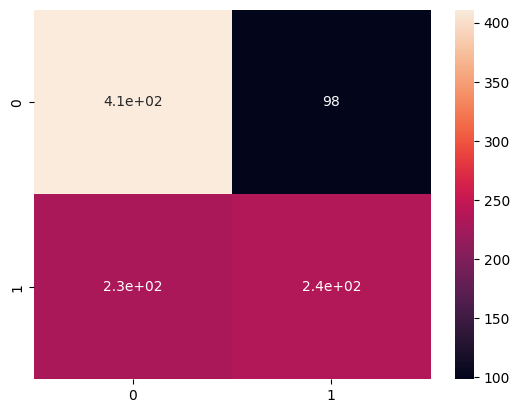

In [302]:
# Print the heatmap
sns.heatmap(confusion_matrix(y_test, search.predict(X_test)), annot=True)



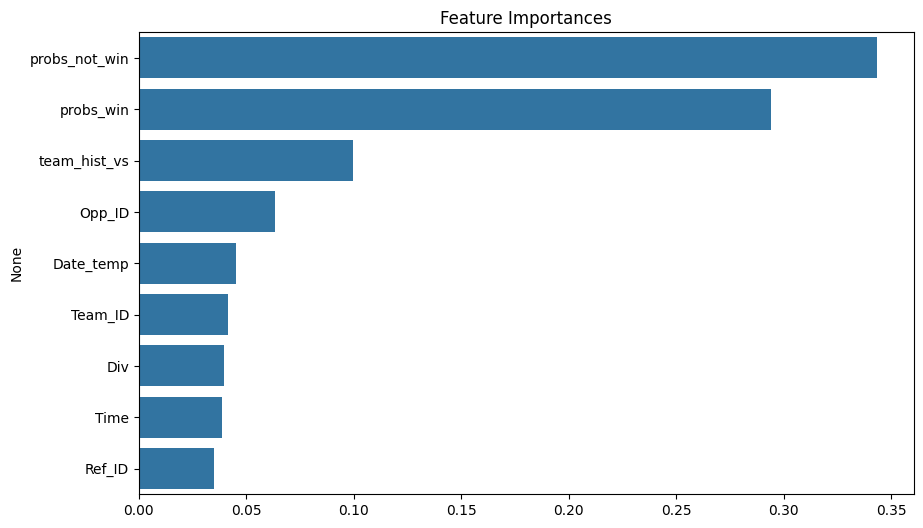

In [303]:
# Show the 20 most important features
importances = search.best_estimator_['xgb'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices][:20], y=X_train.columns[indices][:20])
plt.title('Feature Importances')
plt.show()


### Validation

In [304]:
# Apply the model to the validation set
y_val = df_val['FTR']
X_val = df_val.drop('FTR', axis=1)
y_pred = search.predict(X_val)

# print the classification report
print(classification_report(y_val, y_pred))


ValueError: Mix of label input types (string and number)